# Instalação de bibliotecas

In [ ]:
!pip install --upgrade numpy
!pip install matlplotlib
!pip install seaborn
!pip install gensim
!pip install wordcloud
!pip install unidecode
!pip install nltk

# Importação de bibliotecas

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import string
import gensim
import unidecode
import nltk
import warnings

from tqdm import tqdm
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from matplotlib import style

warnings.filterwarnings("ignore")

C:\Users\OEM\Anaconda3\envs\puc\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Download Stemmer e Stopwords da biblioteca nltk

In [2]:
nltk.download('rslp')
nltk.download('stopwords')

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\OEM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OEM\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

# Definição de configurações gerais do pandas e do matplotlib

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

style.use('fivethirtyeight')

# Lendo DataFrames

In [4]:
reclame_aqui = pd.read_csv('base_reclame_aqui.csv')
twitter = pd.read_csv('base_twitter.csv')

In [5]:
df = reclame_aqui.append(twitter, ignore_index=True)
df.shape

(1200, 1)

In [6]:
df.head()

,reclamacao
0,Gostaria de lamentar app mercado pago pois uso...
1,Olá boa noite!Comprei um tênis na loja Estilo ...
2,Estou a 5 dias tentando recuperar minha conta ...
3,Efetuei o pagamento para uma conta do mercado ...
4,"Nesse tempo de crise, consegui um emprego on-l..."


In [7]:
df_exploratoria = df.copy()
df_modelagem = df.copy()

# Carregando lista de Stopwords de um arquivo .txt

In [ ]:
# stopwords = nltk.corpus.stopwords.words('portuguese')

# with open('stopwords.txt', 'w') as f:
#     for item in stopwords:
#         f.write("%s\n" % item)

In [8]:
lista_stopwords = [line.strip() for line in open('stopwords.txt')]
len(lista_stopwords)

382

# Data preparation

In [9]:
def clean_comentarios_exploratoria(row):
    texto = row['reclamacao']

    # Retirada de acentuação
    texto = unidecode.unidecode(texto)

    # Retirada de pontuação
    texto = ''.join([k.lower() for k in texto if k not in string.punctuation])

    # Retirada de numeração
    texto = ''.join([k for k in texto if not k.isdigit()])

    # Retirada de stopwords
    sem_stop = [p for p in texto.split() if p not in lista_stopwords]

    return sem_stop

df_exploratoria['reclamacao'] = df_exploratoria.apply(clean_comentarios_exploratoria, axis=1)

In [10]:
def clean_comentarios_modelagem(row):
    texto = row['reclamacao']

    # Definição do objeto de Stemming
    stemmer = nltk.stem.RSLPStemmer()

    # Retirada de acentuação
    texto = unidecode.unidecode(texto)

    # Retirada de pontuação
    texto = ''.join([k.lower() for k in texto if k not in string.punctuation])

    # Retirada de numeração
    texto = ''.join([k for k in texto if not k.isdigit()])

    # Retirada de stopwords e aplicação do objeto de Stemming
    sem_stop = [stemmer.stem(p) for p in texto.split() if p not in lista_stopwords]

    return sem_stop

df_modelagem['reclamacao'] = df_modelagem.apply(clean_comentarios_modelagem, axis=1)

# Análise exploratória

In [11]:
df_exploratoria['tamanho_reclamacao'] = df_exploratoria['reclamacao'].map(lambda x: len(x))

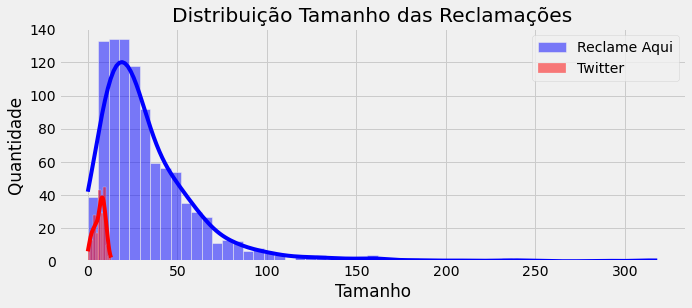

In [12]:
plt.figure(figsize=(10, 4))
sns.histplot(df_exploratoria.loc[0:999, 'tamanho_reclamacao'], color='blue', label='Reclame Aqui', kde=True)
sns.histplot(df_exploratoria.loc[1000:, 'tamanho_reclamacao'], color='red', label='Twitter', kde=True)
plt.legend()
plt.title('Distribuição Tamanho das Reclamações')
plt.xlabel('Tamanho')
plt.ylabel('Quantidade')
plt.show()

In [13]:
df_exploratoria.loc[0:999, 'tamanho_reclamacao'].describe()

count    1000.000000
mean       34.986000
std        33.602871
min         0.000000
25%        15.000000
50%        26.000000
75%        44.250000
max       318.000000
Name: tamanho_reclamacao, dtype: float64

In [14]:
df_exploratoria.loc[1000:, 'tamanho_reclamacao'].describe()

count    200.000000
mean       6.535000
std        2.943142
min        0.000000
25%        4.000000
50%        7.000000
75%        9.000000
max       13.000000
Name: tamanho_reclamacao, dtype: float64

* Quantidade de palavras únicas sem Stemming

In [15]:
palavras_reclamacoes = [y for x in df_exploratoria['reclamacao'].values for y in x]
palavras_unicas_reclamacoes = set(palavras_reclamacoes)
len(palavras_unicas_reclamacoes)

7436

* Quantidade de palavras únicas com Stemming

In [16]:
palavras_reclamacoes_stemming = [y for x in df_modelagem['reclamacao'].values for y in x]
palavras_unicas_reclamacoes_stemming = set(palavras_reclamacoes_stemming)
len(palavras_unicas_reclamacoes_stemming)

4566

* DataFrame com palavras que mais aparecem

In [18]:
string_reclamacoes = ' '.join(x for x in palavras_reclamacoes)

def word_count(string):
    counts = dict()

    words = string.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
            
    return counts


df_rec = pd.DataFrame(word_count(string_reclamacoes).items(), columns=['palavra', 'contagem']).sort_values(by='contagem', ascending=False)
df_rec.head()

,palavra,contagem
63,conta,1014
166,compra,625
230,dinheiro,532
45,valor,464
8,pagamento,427


* Nuvem de palavras Reclame Aqui

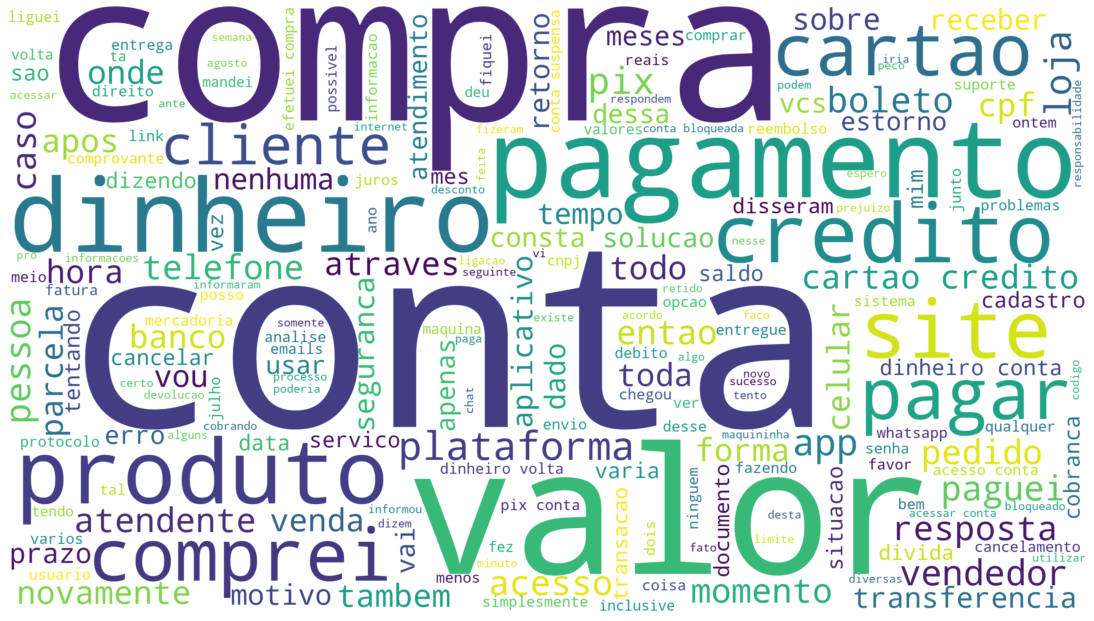

In [19]:
texto = ''

for i in range(1000):
    texto = texto + ' ' + ' '.join(df_exploratoria.loc[i, 'reclamacao'])

wordcloud = WordCloud(background_color='white', stopwords=lista_stopwords, width=2560, height=1440).generate(texto)
barplot_dim = (15, 15)
ax = plt.subplots(figsize=barplot_dim, facecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

* Nuvem de palavras Twitter

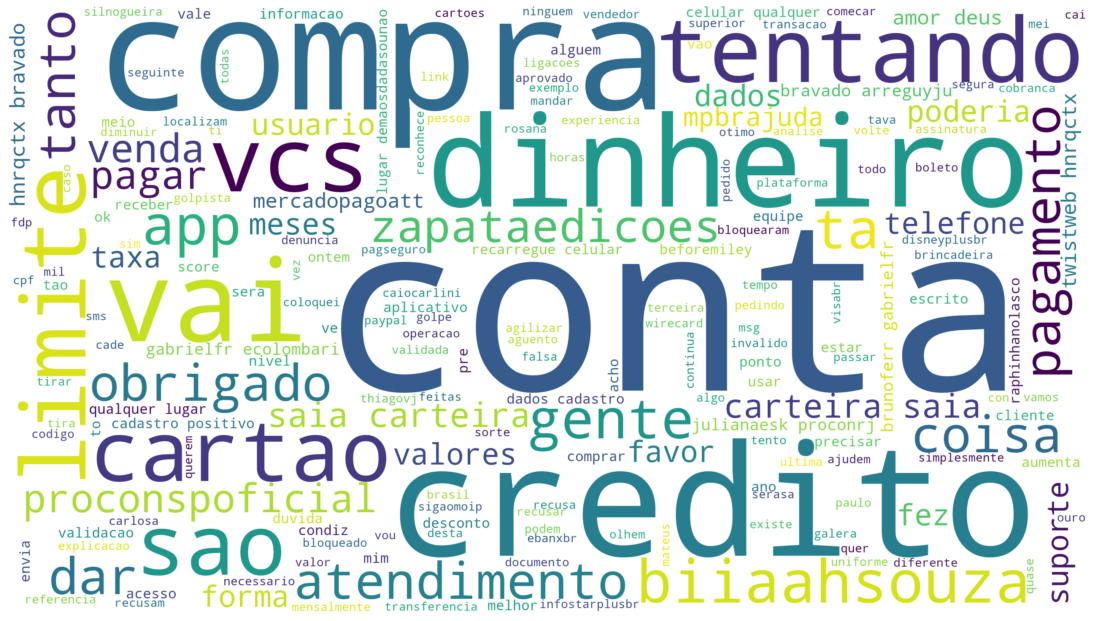

In [20]:
texto = ''

for i in range(1000, 1200, 1):
    texto = texto + ' ' + ' '.join(df_exploratoria.loc[i, 'reclamacao'])

wordcloud = WordCloud(background_color='white', stopwords=lista_stopwords, width=2560, height=1440).generate(texto)
barplot_dim = (15, 15)
ax = plt.subplots(figsize=barplot_dim, facecolor='w')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Algoritmo 1 - Cluster Hierárquico

In [21]:
df_rec[df_rec['contagem'] >= 100].shape

(22, 2)

In [22]:
comentarios_reclamacoes = list(df_exploratoria['reclamacao'].values)
len(comentarios_reclamacoes)

1200

In [27]:
model_reclamacao = gensim.models.Word2Vec(comentarios_reclamacoes, min_count=100, sg=1, vector_size=5)
model_reclamacao.wv.vectors.shape

(22, 5)

In [28]:
model_reclamacao.wv.most_similar('pix')

[('dinheiro', 0.9871295094490051),
 ('compras', 0.9868106842041016),
 ('valor', 0.9758052825927734),
 ('boleto', 0.9727303981781006),
 ('app', 0.9723314642906189),
 ('site', 0.9702215790748596),
 ('plataforma', 0.9669651985168457),
 ('paguei', 0.9669123291969299),
 ('telefone', 0.9650074243545532),
 ('compra', 0.9590083956718445)]

In [29]:
word_vectors = model_reclamacao.wv
l = linkage(model_reclamacao.wv.vectors, method='complete', metric='seuclidean')

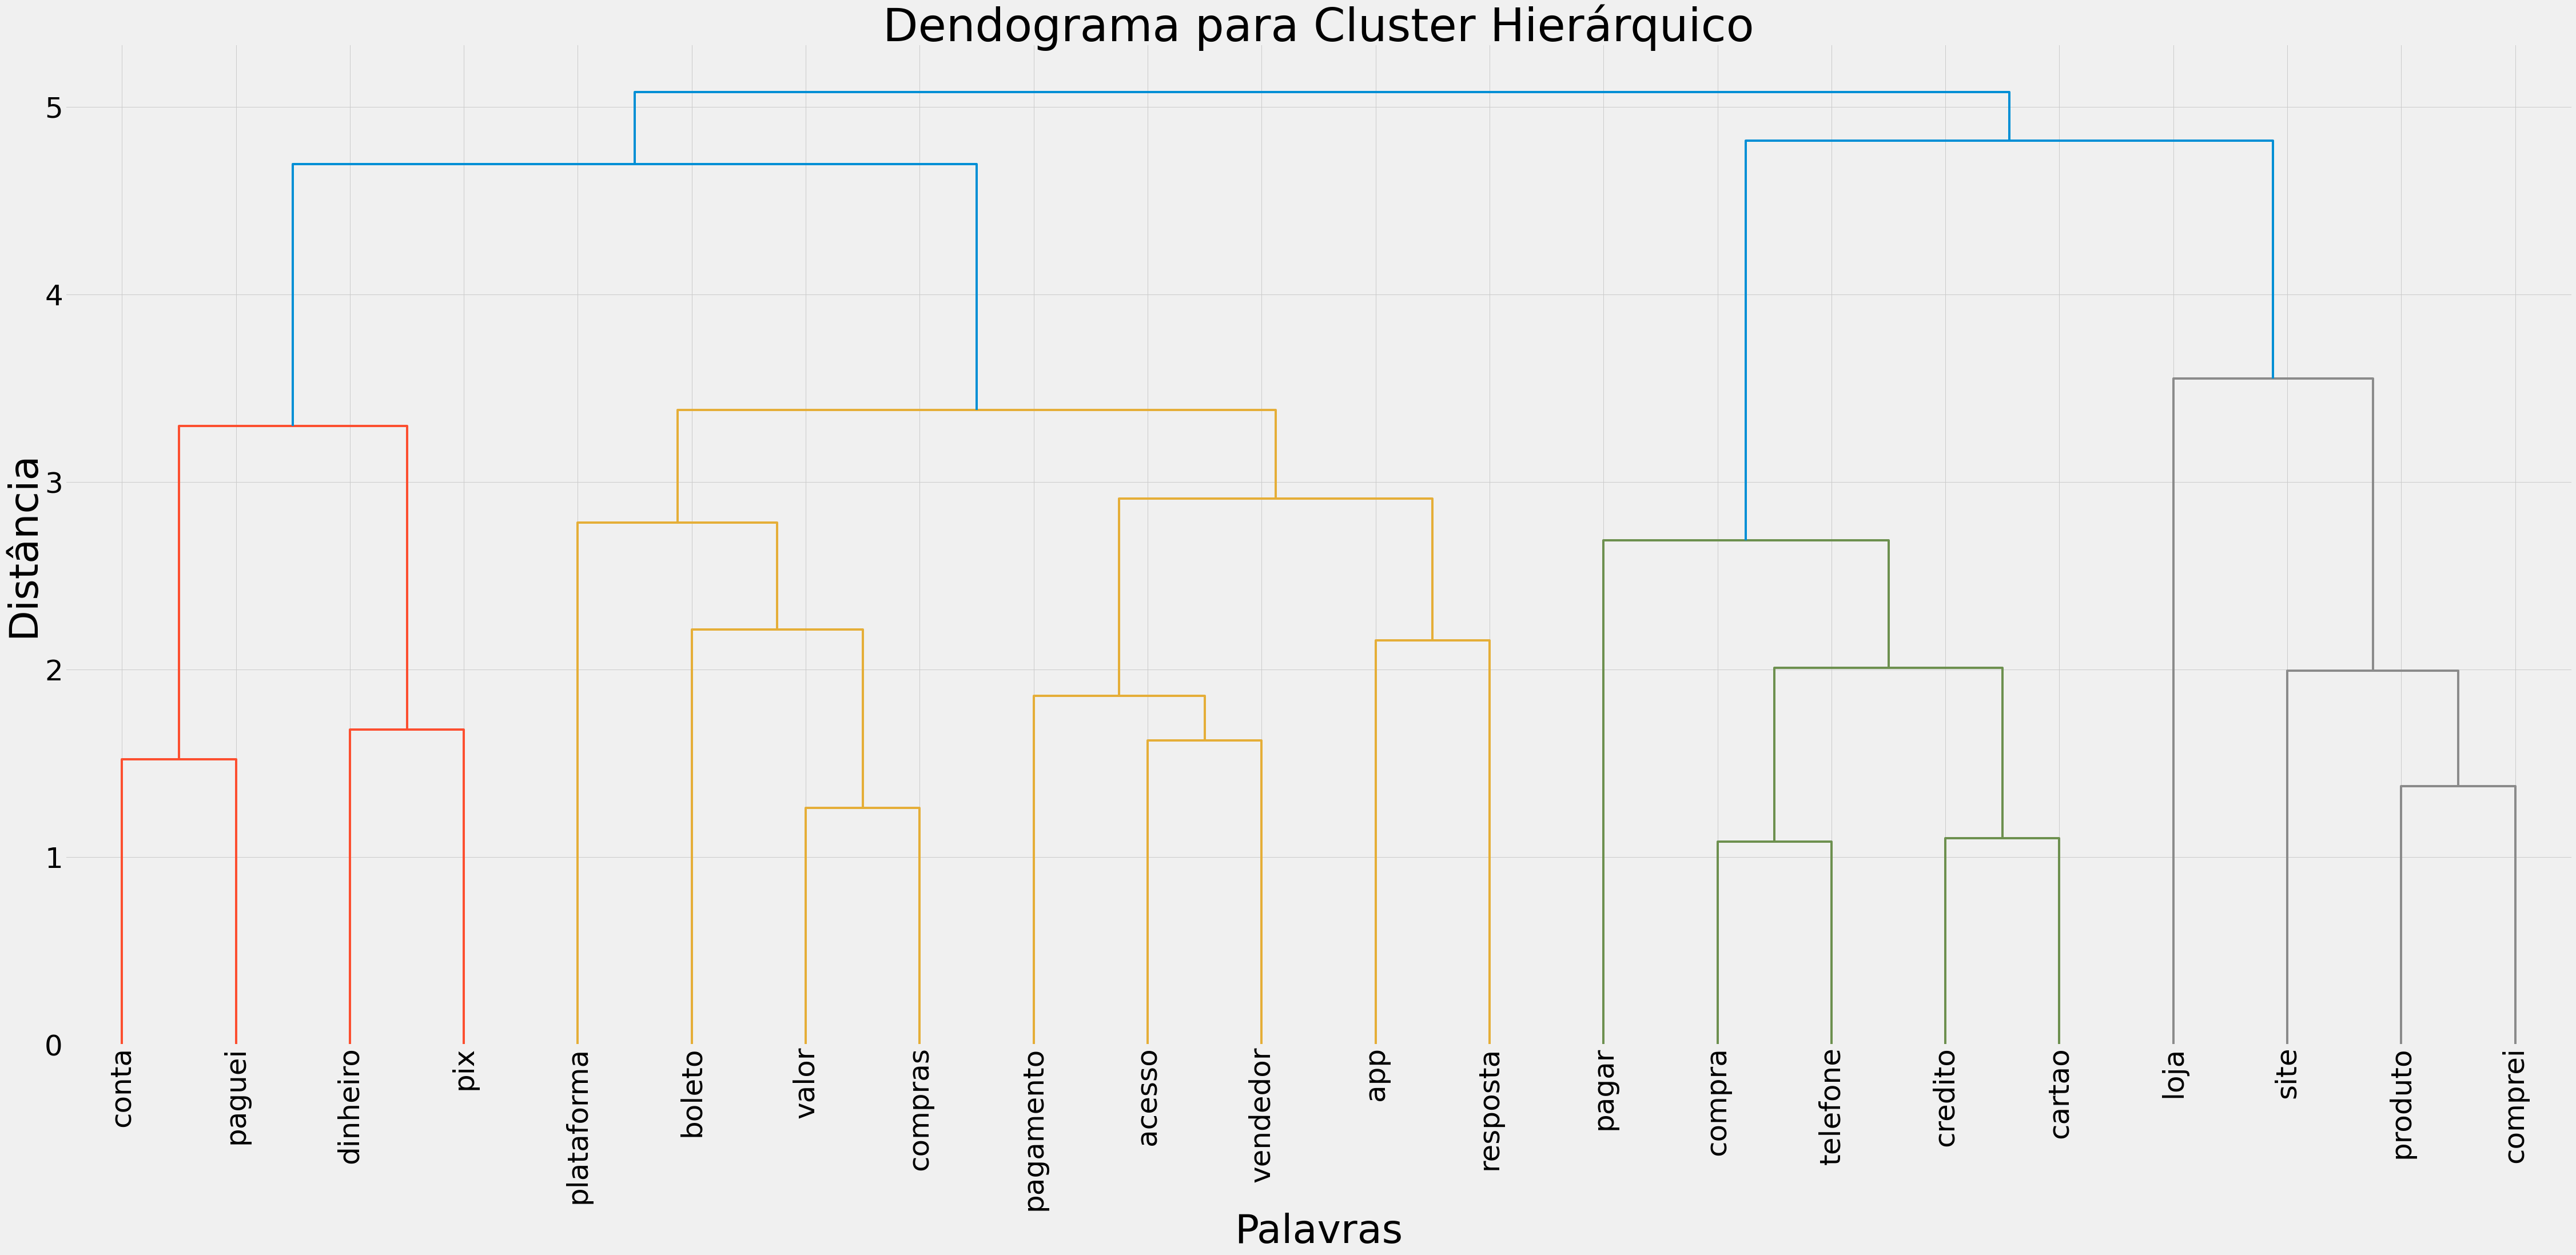

In [30]:
plt.figure(figsize=(70, 30))
plt.title('Dendograma para Cluster Hierárquico', fontsize=80)
plt.xlabel('Palavras', fontsize=70)
plt.ylabel('Distância', fontsize=70)

dendrogram(
    l,
    leaf_rotation=180.,
    leaf_font_size=15.,
    orientation='top',
    leaf_label_func=lambda v: str(model_reclamacao.wv.index_to_key[v])
)

plt.xticks(rotation=90, fontsize=50)
plt.yticks(fontsize=50)
plt.show()

# Algoritmo 2 - K-means

In [31]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=60, max_df=0.5)

In [32]:
df_modelagem['reclamacao_joined'] = df_modelagem['reclamacao'].map(lambda x: ' '.join(x))

In [33]:
comentarios_reclamacao = list(df_modelagem['reclamacao_joined'].values)
X = vectorizer.fit_transform(comentarios_reclamacao)
X.shape

(1200, 94)

In [34]:
vectorizer.get_feature_names()[0:10]

['acess',
 'acess cont',
 'ach',
 'acontec',
 'aguard',
 'aplic',
 'apo',
 'app',
 'atend',
 'atrav']

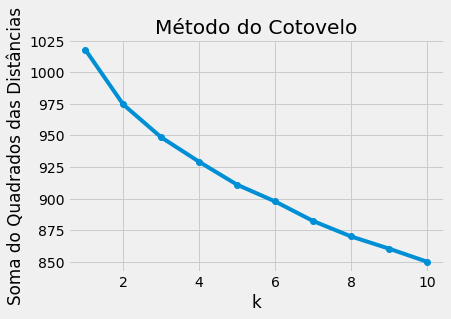

In [35]:
sum_of_squared_distances = []

K = range(1, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=15)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

plt.plot(K, sum_of_squared_distances, 'o-')
plt.xlabel('k')
plt.ylabel('Soma do Quadrados das Distâncias')
plt.title('Método do Cotovelo')
plt.show()

In [36]:
true_k = 5
model = KMeans(n_clusters=true_k, random_state=15)
model.fit(X)

KMeans(n_clusters=5, random_state=15)

In [37]:
labels = model.labels_
df = pd.DataFrame(list(zip(df_modelagem['reclamacao_joined'].values, labels)), columns=['reclamacao', 'cluster'])
df['cluster'].value_counts(normalize=True)

0    0.272500
4    0.245000
3    0.173333
2    0.159167
1    0.150000
Name: cluster, dtype: float64

Cluster: 0


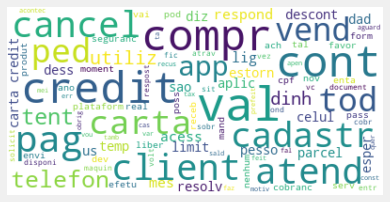

Cluster: 1


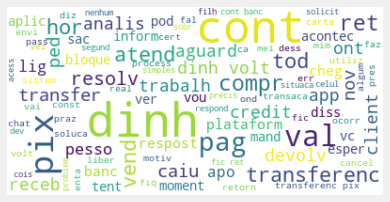

Cluster: 2


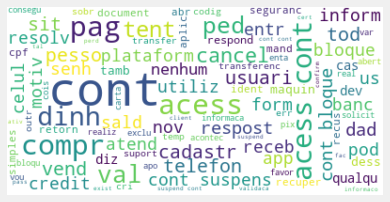

Cluster: 3


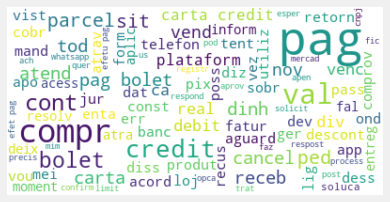

Cluster: 4


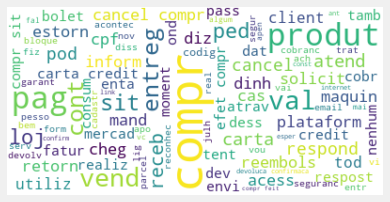

In [38]:
result = {'cluster':labels, 'reclamacoes': df_modelagem['reclamacao_joined'].values}

result = pd.DataFrame(result)

for k in range(0, true_k):
    s = result[result.cluster == k]
    text = s['reclamacoes'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

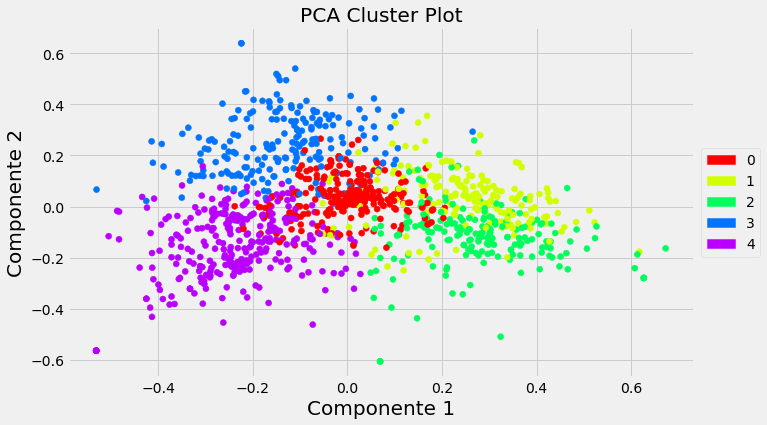

In [39]:
def plot_pca(data, labels):
    max_label = 5

    pca = PCA(n_components=2).fit_transform(data[:, :].todense())
    
    idx = range(1200)
    label_subset = labels
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]

    f, ax = plt.subplots(figsize=(10, 6))

    l1 = mpatches.Patch(color=label_subset[0], label='0')
    l2 = mpatches.Patch(color=label_subset[4], label='1')
    l3 = mpatches.Patch(color=label_subset[2], label='2')
    l4 = mpatches.Patch(color=label_subset[3], label='3')
    l5 = mpatches.Patch(color=label_subset[1], label='4')

    plt.scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    plt.legend(handles=[l1, l2, l3, l4, l5], loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Componente 1', fontsize=20)
    plt.ylabel('Componente 2', fontsize=20)
    ax.set_title('PCA Cluster Plot')

plot_pca(X, labels)

In [40]:
def get_top_keywords(data, clusters, labels, n_terms):

    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i, r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X, labels, vectorizer.get_feature_names(), 10)


Cluster 0
sao,client,app,ped,atend,cadastr,cancel,carta,val,credit

Cluster 1
banc,pag,volt,hor,val,ret,transferenc,cont,pix,dinh

Cluster 2
ped,pag,dinh,val,compr,tent,bloque,acess cont,acess,cont

Cluster 3
cont,sit,parcel,ped,carta,val,credit,compr,bolet,pag

Cluster 4
carta,cancel,loj,val,vend,entreg,pag,sit,produt,compr


# Algoritmo 3 - DBSCAN

In [41]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=100, max_df=0.5)

In [42]:
df_modelagem['reclamacao_joined'] = df_modelagem['reclamacao'].map(lambda x: ' '.join(x))

In [43]:
comentarios_reclamacao = list(df_modelagem['reclamacao_joined'].values)
X = vectorizer.fit_transform(comentarios_reclamacao)
X.shape

(1200, 21)

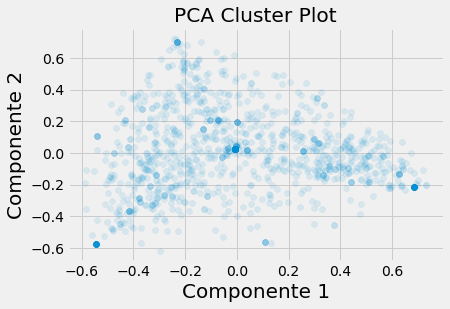

In [44]:
pca = PCA(n_components=2).fit_transform(X[:, :].todense())
plt.scatter(pca[:, 0], pca[:, 1], alpha=0.1)
plt.xlabel('Componente 1', fontsize=20)
plt.ylabel('Componente 2', fontsize=20)
plt.title('PCA Cluster Plot')
plt.show()

In [45]:
db = DBSCAN(min_samples=10).fit(X)

In [46]:
labels = db.labels_
df = pd.DataFrame(list(zip(df_modelagem['reclamacao_joined'].values, labels)), columns=['title', 'cluster'])
df['cluster'].value_counts()

-1    710
 3    156
 0    127
 4    106
 2     32
 1     20
 5     18
 7     11
 6     10
 8     10
Name: cluster, dtype: int64

Cluster: -1


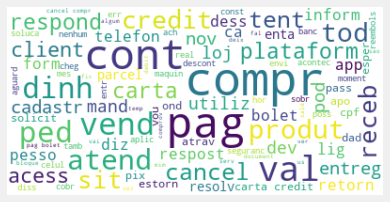

Cluster: 0


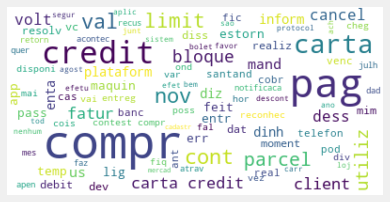

Cluster: 1


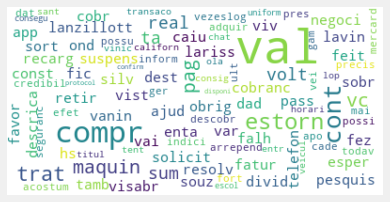

Cluster: 2


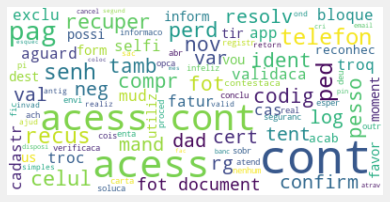

Cluster: 3


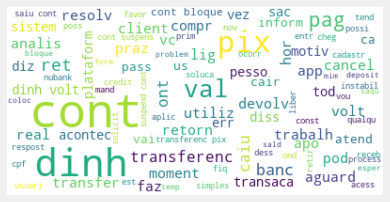

Cluster: 4


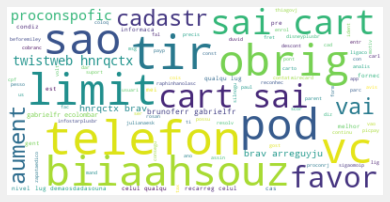

Cluster: 5


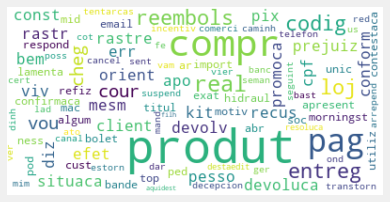

Cluster: 6


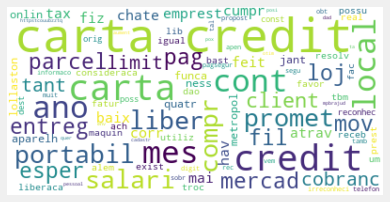

Cluster: 7


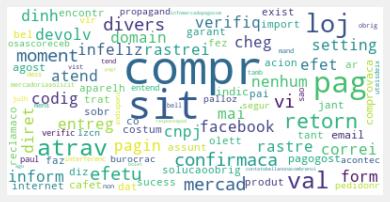

Cluster: 8


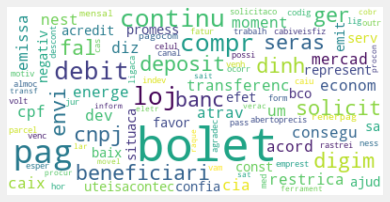

In [47]:
true_k = 9
result={'cluster':labels,'titulos':df['title'].values}
result=pd.DataFrame(result)

for k in range(-1, true_k):
    s = result[result.cluster == k]
    text = s['titulos'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()  


In [48]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

get_top_keywords(X, labels, vectorizer.get_feature_names(), 10)


Cluster -1
credit,produt,atend,vend,ped,dinh,val,cont,pag,compr

Cluster 0
dinh,receb,bolet,cancel,val,cont,carta,credit,pag,compr

Cluster 1
carta,tod,acess,credit,tent,dinh,pag,cont,compr,val

Cluster 2
carta,respost,atend,compr,val,tent,pag,ped,cont,acess

Cluster 3
tod,atend,compr,respost,cancel,pag,val,pix,dinh,cont

Cluster 4
dinh,credit,cont,compr,carta,cancel,bolet,atend,pag,vend

Cluster 5
tod,cancel,ped,bolet,respond,tent,pix,pag,compr,produt

Cluster 6
cancel,bolet,atend,vend,receb,pag,compr,cont,credit,carta

Cluster 7
vend,carta,produt,bolet,atend,dinh,val,pag,compr,sit

Cluster 8
credit,cont,carta,cancel,atend,vend,dinh,compr,pag,bolet
